# First pass at EDA after data migrated to Postgres
28 September 2017

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import datetime
import numpy as np
import re
from dateutil.parser import parse
import spacy
from gensim.models import Phrases
from gensim.models.word2vec import LineSentence
from dateutil.relativedelta import relativedelta

%matplotlib inline

df = pd.read_pickle('../data/postgres_db.pkl')
df['word_count'] = [len(x.split()) if x is not None else 0 for x in df.body]

to_update = []

df.loc[211086,'blog_url'] = 'http://climateaudit.org/'

weird_dates = df[(df.pub_time < pd.Timestamp.min) | (df.pub_time > datetime.datetime.now())]
to_update.append(weird_dates.url)
df.loc[weird_dates.index,'pub_time'] = None

def url_regex(i, df):
    date = re.findall('/(\d{4}/\d{2}/\d{2})', df.loc[i]['url'])
    if date:
        df.loc[i,'pub_time'] = parse(date[0])

null_dates = df[df.pub_time.isnull()]
to_update.append(null_dates.url)
for i, row in null_dates.iterrows():
    url_regex(i, df)

crazy_dates = df[df.pub_time < datetime.datetime(1990, 1, 1)]
to_update.append(crazy_dates.url)
df.loc[crazy_dates.index,'pub_time'] = None
# for i, row in crazy_dates.iterrows():
#     url_regex(i, df)
#     test_year = df.loc[i,'pub_time'] + relativedelta(years=100).year
#     if (test_year > 2000) and (test_year < datetime.datetime.now().year):
#         df.loc[i,'pub_time'] = datetime.datetime(test_year.year, 
#                                                  df.loc[i,'pub_time'].month, 
#                                                  df.loc[i,'pub_time'].day)
#     else:
#         df.loc[i,'pub_time'] = None

df = df[(df.pub_time).notnull()]

len(df)

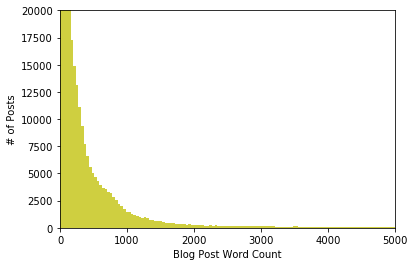

In [12]:
plt.axis([0, 5000, 0, 20000])
plt.xlabel('Blog Post Word Count')
plt.ylabel('# of Posts')
# plt.grid(True)
plt.hist(df.word_count, 10000, facecolor='y', alpha=0.75);

In [13]:
avg_word_count = df.groupby('blog_url').mean()
avg_word_count.sort_values(by='word_count',ascending=True, inplace=True)
aggregagtors = avg_word_count[avg_word_count['word_count'] < 200]

In [14]:
df = df[df.blog_url.isin(aggregagtors.index) == False]

In [15]:
min_date = min(df.pub_time).date()
max_date = max(df.pub_time).date()
print(min_date, max_date)

2000-01-01 2017-10-01


In [16]:
len(df)

151014

In [17]:
grouped = df.groupby('blog_url').count()
grouped.reset_index(inplace=True)
grouped.rename(columns={'url':'post_count'},inplace=True)
grouped = pd.concat([grouped.blog_url, grouped.post_count], axis=1)
grouped.sort_values(by='post_count',ascending=False, inplace=True)
grouped.reset_index(inplace=True, drop=True)

In [ ]:
fig, ax = plt.subplots(figsize=(40, 70))
rects2 = ax.barh(grouped.index, grouped.post_count, color='y');
ax.set_yticks(grouped.index)
ax.set_yticklabels(grouped.blog_url);
ax.invert_yaxis()  # labels read top-to-bottom

In [48]:
ix = pd.DatetimeIndex(start=min_date, end=max_date, freq='M')

def compile_monthly(blog_url, df):
    blog_posts = df[df.blog_url == blog_url]
    blog_posts = blog_posts.set_index(pd.DatetimeIndex(blog_posts['pub_time']))    
    blog_posts = blog_posts.resample('M').count()['url']
    blog_posts = blog_posts.reindex(ix, fill_value=0)
    return blog_posts.values

In [49]:
blogs_to_plot = df[df.blog_url.isin(grouped[0:12]['blog_url'])]
blog_start_date = blogs_to_plot.groupby('blog_url').agg('min')
blog_start_date.sort_values(by='pub_time',ascending=True, inplace=True)
blog_start_date.reset_index(inplace=True)

In [50]:
posts = []
for blog_url in blog_start_date.blog_url:
    posts.append(compile_monthly(blog_url, df))

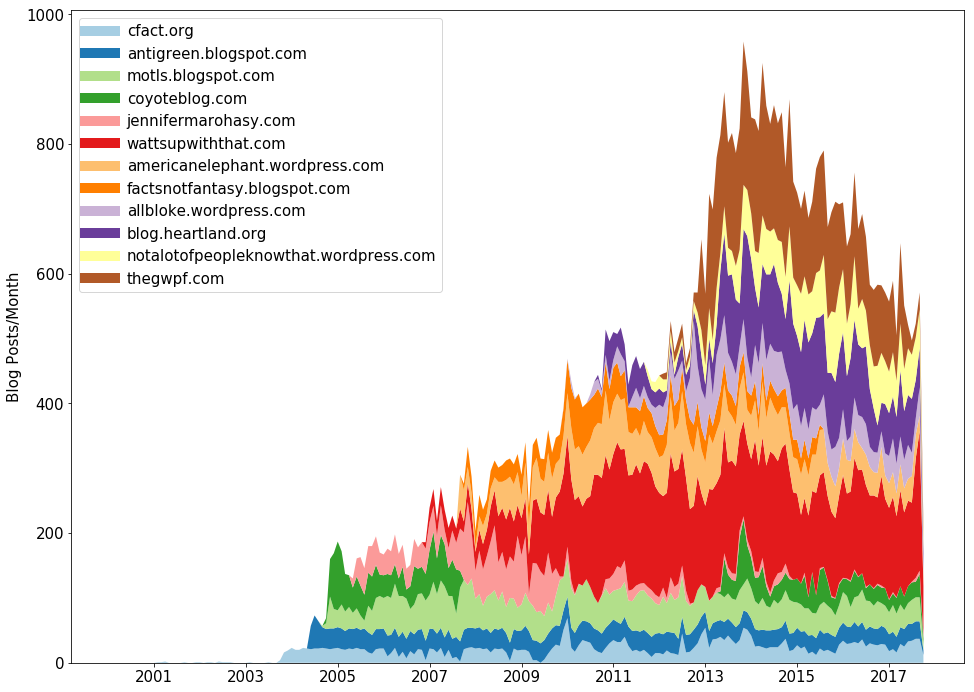

In [52]:
color_list = ['#a6cee3','#1f78b4','#b2df8a','#33a02c','#fb9a99','#e31a1c','#fdbf6f','#ff7f00','#cab2d6','#6a3d9a','#ffff99','#b15928']

fig, ax = plt.subplots(figsize=(16,12));
ax.stackplot(ix, posts[0:12], colors = color_list);

for i in range(12):
    label = blog_start_date.loc[i]['blog_url'].strip('https://')
    label = label.replace('www.','')     
    plt.plot([],[],color=color_list[i], label=label,linewidth=10)

    
plt.tick_params(axis='both', which='major', labelsize=15)
plt.tick_params(axis='both', which='minor', labelsize=15)
plt.ylabel('Blog Posts/Month', fontsize=15)
plt.legend(loc='upper left', fontsize=15)

In [ ]:
blog_posts = df[df.blog_url == 'https://www.thegwpf.com/']

In [ ]:
newer_posts = blog_posts[blog_posts.pub_time > datetime.datetime(2000, 1, 1)]

In [ ]:
newer_posts[newer_posts.pub_time == min(newer_posts['pub_time'])]['url']

In [ ]:
newer_posts.loc[156809]['url']